# Fig 5: Comparison of mean-squared displacement to models with division noise

Here we generate the data for figure 5, which compares the mean-squared displacement between the OU model to a model with division noise

## Setup and Load data

In [47]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

### Load experimental data

In [48]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);

### Load simulations

In [49]:
sims = CSV.read("./../output/sims_models.csv",DataFrame);
sims_gp = CSV.read("./../output/gp/sims_fig5/preds.csv",DataFrame);
τ_range = unique(sims.τ);

## Compare GP to sims in division noise model

Here we check visually that the Gaussian process procedure perserves the structure of growth rates in the division noise model 

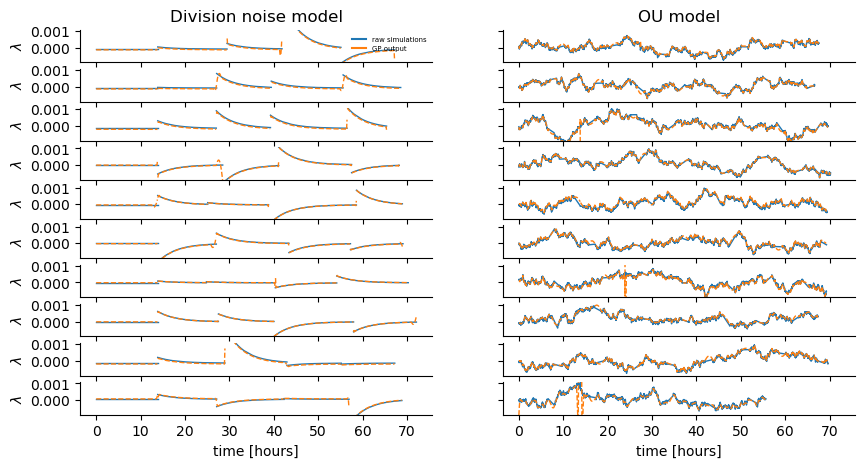

In [50]:
k = 2
lw = 1


fig, axs= subplots(figsize=(10,5),nrows=length(lineages),ncols=2,sharex=true,sharey=true)

for k in eachindex(lineages)

    # ---------------------------------------------------------------------------------
    # Division noise model

    ax = axs[k-1,0]
    d = sims[sims.lineage_original .== lineages[k],:]
    d = d[d.τ .== τ_range[1],:]
    d = d[d.model .== 1,:]
    d = d[d.replicate .==1,:];
    dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    z = d.λ .- mean(d.λ)
    for p in unique(d.position)[1:5]
        ax.plot(d[d.position .== p,:].time .- d.time[1],z[d.position .==p],"C0",lw=lw)
        ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1--",lw=lw)
    end
    ax.set_ylim([min(z...),max(z...)])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.set_ylabel(L"$\lambda$")
    ax.set_title("")

    # ---------------------------------------------------------------------------------
    # OU model 

    ax = axs[k-1,1]
    d = sims[sims.lineage_original .== lineages[k],:]
    d = d[d.τ .== τ_range[1],:]
    d = d[d.model .== 0,:]
    d = d[d.replicate .==1,:];
    dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    z = d.λ .- mean(d.λ)
    for p in unique(d.position)[1:5]
        ax.plot(d[d.position .== p,:].time .- d.time[1],z[d.position .==p],"C0",lw=lw)
        ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1--",lw=lw)
    end
    ax.set_ylim([min(z...),max(z...)])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
end

axs[0,0].set_title("Division noise model")
axs[0,1].set_title("OU model")
axs[0,0].plot([0],[0],"C0-",label="raw simulations")
axs[0,0].plot([0],[0],"C1-",label="GP output")
axs[-1,0].set_xlabel("time [hours]")
axs[-1,1].set_xlabel("time [hours]")
axs[0,0].legend(frameon=false,fontsize=5)

fig

## Mean-squared displacement comparison 

### MSD Setup 

In [75]:
function MSD(x,max_steps)
    n = length(x)
    msd = zeros(max_steps)
    for i in 1:max_steps 
        msd[i] = mean((x[1:end-i] .- x[i+1:end]).^2)
    end
    return msd
end

function make_msd_dataframe(df,steps,col)
    msd_all = MSD(df[:,col],steps)
    msd_within = mean(hcat([MSD(df[df.position .==p,col],steps) for p in unique(df.position)]...),dims=2)[:,1]
    dt = mean(diff(df[:,:time]))
    times = collect(0:1:(steps-1))*dt
    ratio = (msd_within ) ./ (msd_within  .+ msd_all)
    dict = Dict(:msd_all => msd_all,:msd_within => msd_within,:lag => times,:ratio => ratio)
    msf_df = DataFrame(dict)
end


function apply_msd_to_groups(df, steps, col, group_col)
    # Define a wrapper function to pass to combine
    function msd_per_group(sub_df)
        return make_msd_dataframe(sub_df, steps, col)
    end

    # Use combine to apply the function to each group and concatenate the results
    combined_df = combine(groupby(df, group_col), msd_per_group)

    return combined_df
end


apply_msd_to_groups (generic function with 1 method)

In [96]:

lineage_map(1)

3-element Vector{Float64}:
 2.0
 0.0
 1.0

In [108]:
msd_sims = apply_msd_to_groups(sims_gp, steps,"matern32notrend_flucs_x", :lineage);
msd_data = apply_msd_to_groups(data_gp, steps,"matern32_flucs_x", :lineage);

# add original information to msd_sims
lineage_map = l -> Array(sims[sims.lineage .== l,[:τ,:model,:lineage_original]])[1,:]
msd_sims = hcat(msd_sims,DataFrame(hcat(lineage_map.(msd_sims.lineage)...)',[:τ,:model,:lineage_original]))
CSV.write("./../output/msd_sims.csv",msd_sims)
CSV.write("./../output/msd_data.csv",msd_data)


"./../output/msd_data.csv"

### Make MSD Figure

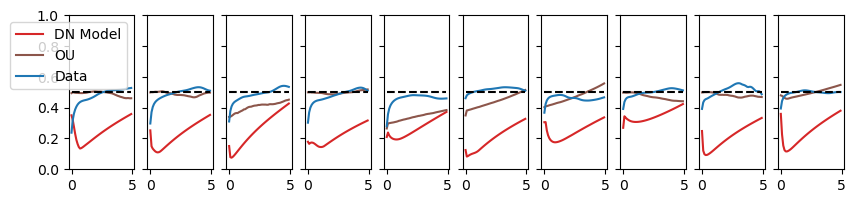

In [85]:
fig, axs= subplots(figsize=(10,2),ncols=length(lineages),nrows=1,sharex=true,sharey=true)
steps = 50
for k in eachindex(lineages)

    ax = axs[k-1]

    # first get the raw simulation dataframe we want 
    d = sims[sims.lineage_original .== lineages[k],:]
    d = d[d.τ .== τ_range[1],:]
    d = d[d.replicate .==1,:];
    
    
    # ----------------------------------------------------------------------
    # OU MODEl 
    # get the dataframe corresponding to model 1
    dm = msd_sims[msd_sims.lineage.== d[d.model .== 1,:].lineage[1],:];
    # plot MSD ratio 
    ax.plot(dm.lag,dm.ratio,"C3-",label="DN Model")

    # ----------------------------------------------------------------------
    # OU MODEl 
    # get the dataframe corresponding to model 1
    dgp = sims_gp[sims_gp.lineage.== d[d.model .== 0,:].lineage[1],:];
    msd_df = make_msd_dataframe(dgp,steps,"matern32notrend_flucs_x") 

    # plot MSD ratio 
    ax.plot(msd_df.lag,msd_df.ratio,"C5-",label="OU")

    # ----------------------------------------------------------------------
    # DATA
    dd = data_gp[data_gp.lineage.== lineages[k],:]
    msd_df = make_msd_dataframe(dd,steps,"matern32_flucs_x") 

    # plot MSD ratio 
    ax.plot(msd_df.lag,msd_df.ratio,"C0-",label="Data")



    # dd = data_gp[data_gp.lineage.== lineages[k],:]
    # m1 = MSD(dd.matern32_flucs_x,steps)
    # m2 = mean(hcat([MSD(dd[dd.position .== p,:].matern32_flucs_x,steps) for p in unique(dd.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C5-",label="data")


    

    #ax = axs[k-1]
    # d = sims[sims.lineage_original .== lineages[k],:]
    # d = d[d.τ .== τ_range[1],:]
    # d = d[d.model .== 0,:]
    # d = d[d.replicate .==1,:];
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    # ------------------------------------------------------------------------------------
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];
    # m1 = MSD(dgp.matern32notrend_flucs_x,steps)
    # m2 = mean(hcat([MSD(dgp[dgp.position .== p,:].matern32notrend_flucs_x,steps) for p in unique(dgp.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C4--",label="OU")
    ax.plot(msd_df.lag,ones(steps)/2,"k--")


end
axs[0].legend()
axs[0].set_ylim([0,1])
fig

# Misc

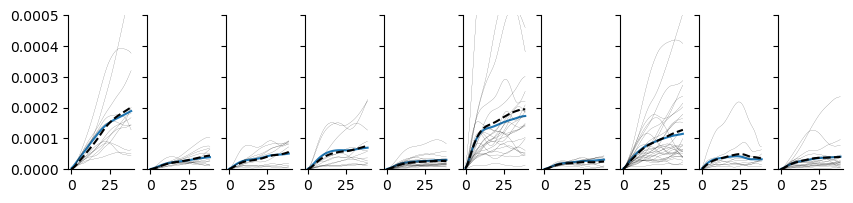

In [8]:
fig,axs = subplots(figsize=(10,2),ncols = length(lineages),sharex=true,sharey=true)

for k in eachindex(lineages)
    ax = axs[k-1]
    df = data_gp[data_gp.lineage .== lineages[k],:]
    x = df.matern32_flucs_x
    msdx = MSD(x,40)
    ax.plot(msdx)
    mw = []
    for p in unique(df.position)
        xw = df[df.position .==p,:matern32_flucs_x]
        y = MSD(xw,40)
        push!(mw,y)
        ax.plot(y,"k-",lw=0.1)
    end
    mw = hcat(mw...)
    μ = mean(mw,dims=2)
    ax.plot(μ,"k--")
    v = var(mw,dims=2)
   # ax.fill_between(collect(1:length(μ)),μ[1] .- v[1],μ[1])
    ax.set_ylim([0.,0.0005])
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
savefig("./../figures/MSD.pdf")
fig

In [ ]:
xw = df[df.position .==2,:matern32_flucs_x]
mw = MSD(xw,20)

xb = df[:,:matern32_flucs_x]
mw = MSD(xw,20)

The key conclusion at this point is that the simple model perserves the statistics the GP output. Can we reject H1: The data is from the OU model + trend? Our test statisic is  $$\hat{T}=  MSD-0.5.$$

We can estimate $$P(T>\hat{T}|H_1)$$ where


We obtain the sample distribution of $\hat{T}$ numericaly for a two parameter class of models, which interpolates between the pure OU model, constant per cell-cycle and jump with exponential relaxation. These captures models from previous studies.